In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder , OneHotEncoder


# Read the data 


In [2]:
df = pd.read_csv('bank_data.csv')

In [3]:
df.sample(5)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
1302,529,3155,4811.161772,Level 3 Recovery,60,Female
1607,1071,4936,8704.052259,Level 3 Recovery,54,Male
718,777,1628,1411.792353,Level 1 Recovery,42,Female
44,1981,703,414.065000,Level 0 Recovery,31,Male
816,145,1787,1093.305010,Level 1 Recovery,24,Female


# Data Cleaning 

In [4]:
# check missing values
df.isnull().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [5]:
# check duplicate values
df.duplicated().sum()

0

<Axes: >

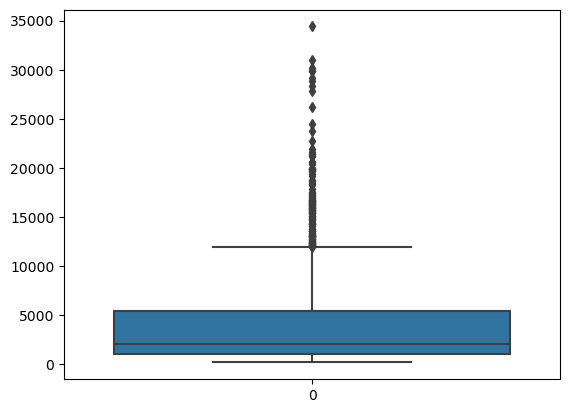

In [6]:
sns.boxplot(df['actual_recovery_amount'])

<function matplotlib.pyplot.show(close=None, block=None)>

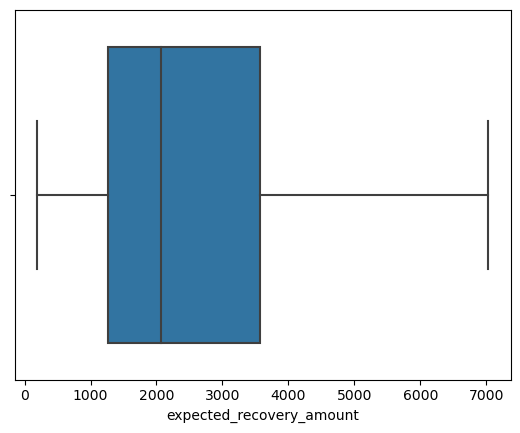

In [7]:
def replace_outlier(col):
  sorted(col)
  Q1,Q3=col.quantile([0.25,0.75])
  IQR=Q3-Q1
  lower_ranger=Q1-(1.5*IQR)
  upper_ranger=Q3+(1.5*IQR)
  return lower_ranger, upper_ranger
lowVisibility, uppVisibility = replace_outlier(df['expected_recovery_amount'])
df['expected_recovery_amount']=np.where(df['expected_recovery_amount']>uppVisibility,uppVisibility,df['expected_recovery_amount'])
df['expected_recovery_amount']=np.where(df['expected_recovery_amount']<lowVisibility,lowVisibility,df['expected_recovery_amount'])
sns.boxplot(x=df['expected_recovery_amount'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

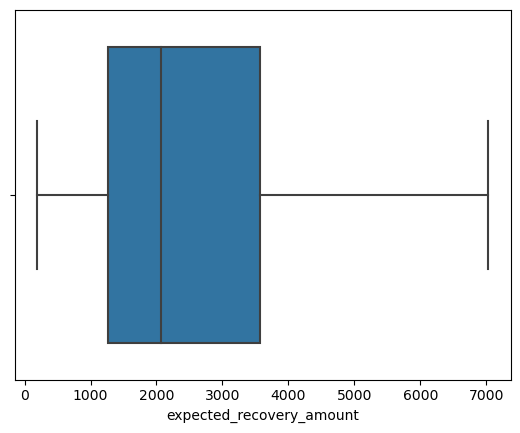

In [8]:
def replace_outlier(col):
  sorted(col)
  Q1,Q3=col.quantile([0.25,0.75])
  IQR=Q3-Q1
  lower_ranger=Q1-(1.5*IQR)
  upper_ranger=Q3+(1.5*IQR)
  return lower_ranger, upper_ranger
lowVisibility, uppVisibility = replace_outlier(df['expected_recovery_amount'])
df['expected_recovery_amount']=np.where(df['expected_recovery_amount']>uppVisibility,uppVisibility,df['expected_recovery_amount'])
df['expected_recovery_amount']=np.where(df['expected_recovery_amount']<lowVisibility,lowVisibility,df['expected_recovery_amount'])
sns.boxplot(x=df['expected_recovery_amount'])
plt.show

# Prepare the data for our model 


In [9]:
df.sample(1)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
1342,857,3325.0,4015.654622,Level 3 Recovery,43,Female


In [10]:
df['recovery_strategy'].value_counts()

Level 1 Recovery    670
Level 3 Recovery    368
Level 2 Recovery    333
Level 4 Recovery    264
Level 0 Recovery    247
Name: recovery_strategy, dtype: int64

In [11]:
recovry_label_encoder  =df['recovery_strategy'].map({
    'Level 0 Recovery' : 0  , 
    'Level 1 Recovery' : 1  ,
    'Level 2 Recovery' : 2  ,
    'Level 3 Recovery' : 3  ,
    'Level 4 Recovery' : 4  ,
})

In [12]:
onhot_sex = pd.get_dummies(df['sex']  )

In [13]:
onhot_sex

,Female,Male
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
1877,1,0
1878,1,0
1879,1,0
1880,1,0


In [15]:
df = pd.concat([df , onhot_sex ] , axis = 1)

In [20]:
df.drop(['recovery_strategy' , 'sex' ] , inplace= True , axis = 1)

In [23]:
df_clean = pd.concat([df , recovry_label_encoder] , axis = 1)

In [24]:
df_clean.sample(5)

,id,expected_recovery_amount,actual_recovery_amount,age,Female,Male,recovery_strategy
457,1826,1247.0,647.224966,31,0,1,1
386,2006,1154.0,939.097314,25,1,0,1
1412,1652,3574.0,5176.308380,59,1,0,3
413,1623,1189.0,973.686663,31,1,0,1
48,283,715.0,370.925000,26,0,1,0


In [25]:
df.drop('id' , inplace= True , axis = 1)

# The model 

In [31]:
df_clean.drop('id' , inplace= True , axis = 1)

In [33]:
X = df_clean.drop('expected_recovery_amount' , axis = 1)
y = df_clean['expected_recovery_amount']

In [34]:
# split the data into train and test
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [35]:
#metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.model_selection  import cross_val_score as CVS


#ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [36]:
def cross_val(model_name,model,X,y,cv):

    scores = CVS(model, X, y, cv=cv)
    print(f'{model_name} Scores:')
    for i in scores:
        print(round(i,2))
    print(f'Average {model_name} score: {round(scores.mean(),4)}')

In [39]:
# standardize the data
from sklearn.preprocessing import StandardScaler
df_clean = StandardScaler().fit_transform(df_clean)


In [47]:
#model
LR = LinearRegression()

#fit
LR.fit(X_train, y_train)

#predict
y_predict = LR.predict(X_test)

#score variables
LR_MAE = round(MAE(y_test, y_predict),2)
LR_MSE = round(MSE(y_test, y_predict),2)
LR_R_2 = round(R2(y_test, y_predict),4)
LR_CS  = round(CVS(LR, X, y, cv=5).mean(),4)

print(f" Mean Absolute Error: {LR_MAE}\n")
print(f" Mean Squared Error: {LR_MSE}\n")
print(f" R^2 Score: {LR_R_2}\n")
cross_val(LR,LinearRegression(),X,y,5)

 Mean Absolute Error: 351.02

 Mean Squared Error: 211545.33

 R^2 Score: 0.9417

LinearRegression() Scores:
-6.6
-0.77
-0.93
-0.95
-0.64
Average LinearRegression() score: -1.9774


In [48]:
#model
RFR= RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4,random_state=101)
#fit
RFR.fit(X_train, y_train)
#predict
y_predict = RFR.predict(X_test)

#score variables
RFR_MAE = round(MAE(y_test, y_predict),2)
RFR_MSE = round(MSE(y_test, y_predict),2)
RFR_R_2 = round(R2(y_test, y_predict),4)
RFR_CS  = round(CVS(RFR, X, y, cv=5).mean(),4)



print(f" Mean Absolute Error: {RFR_MAE}\n")
print(f" Mean Squared Error: {RFR_MSE}\n")
print(f" R^2 Score: {RFR_R_2}\n")
cross_val(RFR,RandomForestRegressor(),X,y,5)

 Mean Absolute Error: 337.71

 Mean Squared Error: 198795.08

 R^2 Score: 0.9453

RandomForestRegressor(max_depth=5, min_samples_leaf=100, n_estimators=200,
                      n_jobs=4, random_state=101) Scores:
-5.89
-2.44
-2.65
-2.91
-3.93
Average RandomForestRegressor(max_depth=5, min_samples_leaf=100, n_estimators=200,
                      n_jobs=4, random_state=101) score: -3.5629
